# Introdução às redes neurais e TensorFlow

Para chegar à implementação de uma rede neural simples, vamos começar com um problema velho conhecido nosso: a regressão logística.

Relembrando: a regressão logística (que não é uma regressão, e sim um modelo de classificação) usa a função logística:

$$
y = \sigma(x) = \frac{1}{1 + \exp(-x)}
$$

Vamos implementá-la e visualizá-la:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

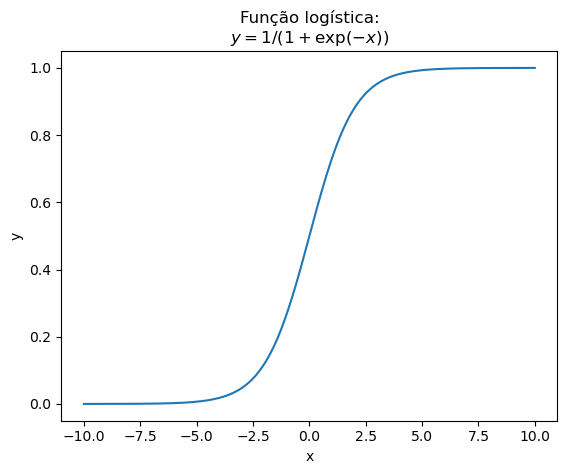

In [2]:
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))


xs = np.linspace(-10.0, 10.0, 200)
ys = logistic(xs)

plt.figure()
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Função logística:\n$y = 1/(1 + \exp(-x))$")
plt.show()

No contexto da regressão logística, a função logística será usada para representar a probabilidade de que um objeto $x$ pertença à classe positiva.

Do jeito que está, a função logística permite apenas distinguir valores negativos de $x$ (quando $\sigma(x) < 0.5$ de valores positivos de $x$ (quando $\sigma(x) > 0.5$). Para "esticar" a função logística podemos usar um peso aplicado a $x$: quando esse peso é maior que $1$ a função encolhe, e quando é menor que $1$ a função alarga:

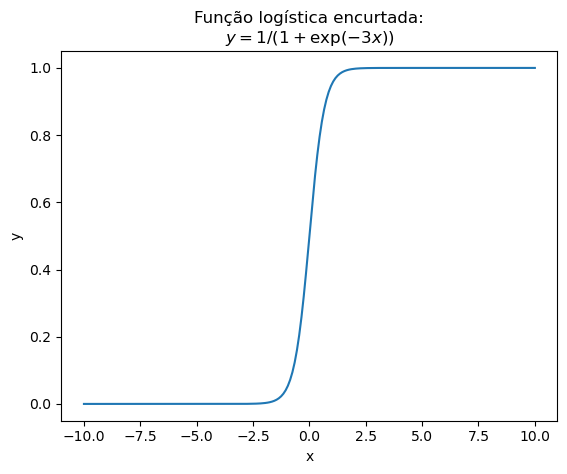

In [3]:
w = 3
ys = logistic(w * xs)

plt.figure()
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Função logística encurtada:\n$y = 1/(1 + \exp(-{w} x))$")
plt.show()

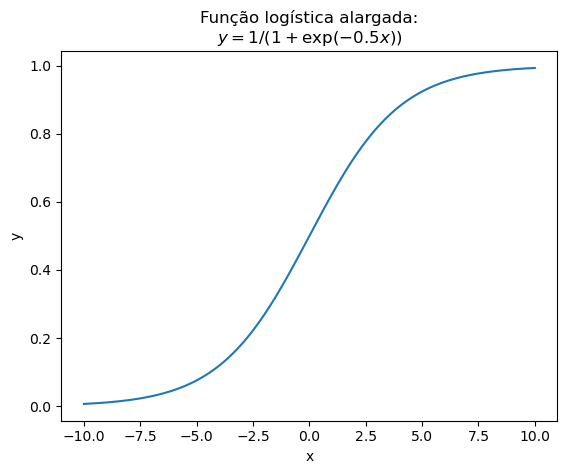

In [4]:
w = 0.5
ys = logistic(w * xs)

plt.figure()
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Função logística alargada:\n$y = 1/(1 + \exp(-{w} x))$")
plt.show()

Para mover a função logística, podemos somar uma constante ao argumento $x$. Valores positivos da constante deslocam a função logística para a direção negativa, e valores negativos deslocam a função para a direção positiva:

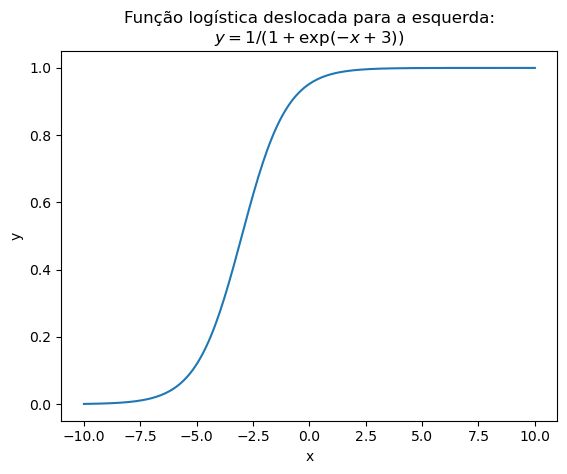

In [5]:
b = 3
ys = logistic(xs + b)

plt.figure()
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("y")
plt.title(
    f"Função logística deslocada para a esquerda:\n$y = 1/(1 + \exp(-x + {b}))$"
)
plt.show()

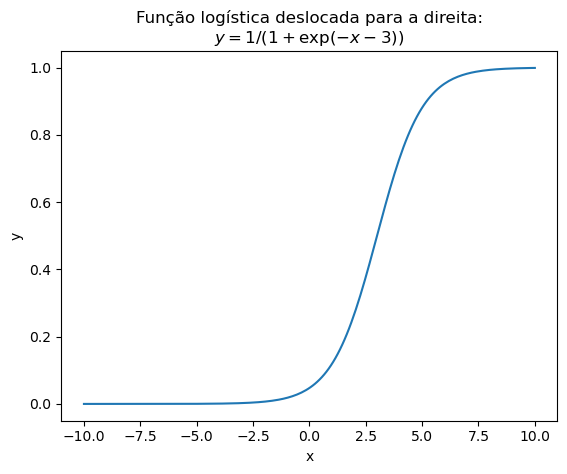

In [6]:
b = -3

ys = logistic(xs + b)

plt.figure()
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("y")
plt.title(
    f"Função logística deslocada para a direita:\n$y = 1/(1 + \exp(-x - {-b}))$"
)
plt.show()

Combinando os dois elementos (o peso e a constante) podemos mover e esticar a função logística à vontade.

E se a entrada $x$ for multivalorada? Para considerar um exemplo totalmente ao acaso, queremos distinguir entre dois tipos de flores a partir do comprimento e da largura da pétala. Neste caso nossa entrada $x$ tem dois valores. Por conveniência, vamos representar uma entrada como uma matriz linha, para ficar consistente com a nossa representação futura de multiplos pontos como uma matriz:

$$
x = \left[
\begin{matrix}
x_0 & x_1
\end{matrix}
\right]
$$

Nossos pesos agora são um vetor de dois valores:

$$
w = \left[
\begin{matrix}
w_0 \\
w_1
\end{matrix}
\right]
$$

e nossa constante continua sendo um valor apenas.

A combinação de valores pré-função-logística fica sendo:

$$
v = x w + b
$$

onde o produto da expressão é uma multiplicação de matrizes.

Vamos implementar esta operação em separado:

In [7]:
def linear(w, b, x):
    return x @ w + b

A operação `@` para multiplicação de matrizes foi introduzida no Python 3.5, na PEP 465.

Vamos visualizar o resultado de aplicar um vetor de pesos e uma constante à nossa função logística. Primeiro vamos gerar vários pontos cobrindo o quadrado de lado $20.0$ centrado na origem.

In [8]:
xs = np.linspace(-10.0, 10.0, 200)
ys = np.linspace(-10.0, 10.0, 200)

Xs, Ys = np.meshgrid(xs, ys)
Xs.shape

(200, 200)

Agora vamos rearranjar estes valores na forma de uma matriz de amostras de $200 \times 200 = 40000$ linhas e $2$ colunas (uma para os `Xs` e outra para os `Ys`):

In [9]:
X = np.c_[Xs.reshape(-1, 1), Ys.reshape(-1, 1)]
X.shape

(40000, 2)

Agora podemos aplicar diretamente as funções `linear(w, b, x)` e `logistic(x)`! Pela magia do `numpy`, as operações já estão definidas para operação matricial. Só precisamos definir corretamente os pesos e a constante:

In [10]:
w = np.array([
    [-3.0],
    [5.0],
])

b = -2.0

v = linear(w, b, X)
z = logistic(v)

Vamos retornar a forma do array `z` para que seja compatível com `Xs` e `Ys`:

In [11]:
Zs = z.reshape(Xs.shape)
Zs.shape

(200, 200)

Agora é só plotar:

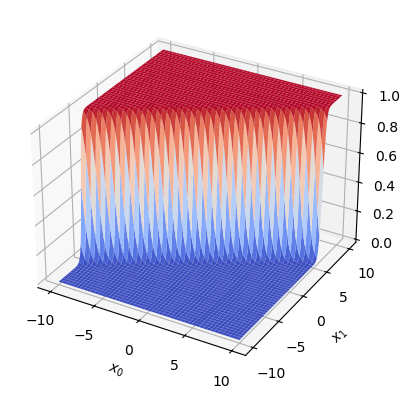

In [12]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(Xs, Ys, Zs, cmap=cm.coolwarm)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.show()

Podemos visualizar a estrutura que criamos aqui com o diagrama a seguir:

![](logistic.png)

Neste diagrama, os pesos incluidos nas arestas representam multiplicação, e o circulo representa a soma dos valores entrantes.

Isto é o nosso primeiro neurônio artificial! No linguajar das redes neurais, temos aqui uma camada de $2$ entradas, $1$ saída, e *função de ativação* logística.

A questão agora é: como treinar a rede?

**Atividade**: Selecione manualmente pesos e constante que façam com que a regressão logística resolva o seguinte problema de classificação:

| $x_0$ | $x_1$ | $y$ |
|-------|-------|-----|
| 0 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

**R**: 

## Implementando a regressão logistica

A função logística acima é um *modelo paramétrico*. Com os parâmetros corretos, permite atribuir a uma amostra $x$ uma probabilidade $\hat{y}$ (note o uso de chapeu para indicar *valor estimado*) de pertencimento à classe positiva.

Como podemos *definir* o que são parâmetros corretos? Como de costume em *machine learning* podemos definir os parâmetros corretos como sendo aqueles que minimizam um valor médio de *perda*, *custo* ou *erro* para um conjunto de amostras de treinamento.

No caso da regressão logística, a *perda* para uma amostra $(x, y)$ é dada pela *entropia cruzada*:

$$
l(y, \hat{y}) = -y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})
$$

A perda média sobre um conjunto de $m$ amostras de dimensão (features) $n$, representado como uma matriz $X_{m \times n}$ e um vetor $y_{m \times 1}$, é dada por:

$$
L(y, \hat{y}) = \frac{1}{m} \sum_{i = 1}^{m} l(y_i, \hat{y}_i)
$$

Pela magia do `numpy`, a implementação abaixo funciona para qualquer número de amostras:

In [13]:
def loss(y, y_pred):
    return np.mean(-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred))

Temos um modelo e uma definição de perda, que deve ser minimizada. Falta definir o algoritmo de otimização. Como de costume, vamos usar o *gradient descent*. Devemos lembrar que, ao fixar as amostras de treinamento, nossa função de perda passa a depender somente dos pesos e da constante:

$$
L(y, \hat{y}(w, b, X)) = L(w, b) \, \text{para $X$ e $y$ fixos}
$$

O algoritmo *gradient descent* vai precisar dos gradientes da função de perda média em relação aos parâmetros $w$ e $b$:

$$
\nabla_w L(w, b) = \frac{\partial L}{\partial w} =  \frac{1}{m} X^T (\hat{y} - y)
$$

$$
\nabla_b L(w, b) = \frac{dL}{db} =  \frac{1}{m} \sum_{i = 1}^{m} (\hat{y}_i - y_i)
$$

(acredite)

Abaixo temos a implementação desta função.

In [14]:
def grad(X, y, y_pred):
    m = y.shape[0]
    grad_w = (1.0 / m) * X.transpose() @ (y_pred - y)
    grad_b = (1.0 / m) * np.sum(y_pred - y)
    return grad_w, grad_b

Vamos criar um conjunto de exemplos de treinamento bem simples:

In [15]:
X = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])
y = np.array([
    [0.0],
    [0.0],
    [0.0],
    [1.0],
])

Agora vamos inicializar os *parâmetros treináveis* (os pesos e a constante). Para nosso exemplo simples de regressão logística a inicialização dos parâmetros não é tão crítica, mas para uma rede neural complexa a inicialização é assunto muito delicado, e pesquisas continuam acontecendo nessa área!

In [16]:
w = np.array([
    [0.0],
    [0.0],
])
b = 0.0

Agora vamos implementar o algoritmo de otimização. O correto é monitorar o erro e parar quando o erro não melhorar mais, mas por simplicidade vamos omitir esta parte do algoritmo:

In [17]:
max_epochs = 1000
eta = 1.0

perda = []  # Para poder plotar a perda depois.

for _ in range(max_epochs):
    y_pred = logistic(linear(w, b, X))
    eps = loss(y, y_pred)
    perda.append(eps)

    grad_w, grad_b = grad(X, y, y_pred)
    w -= eta * grad_w
    b -= eta * grad_b

In [18]:
eps

np.float64(0.017431844934779856)

In [19]:
w, b,

(array([[7.41431138],
        [7.41431138]]),
 np.float64(-11.294073552477853))

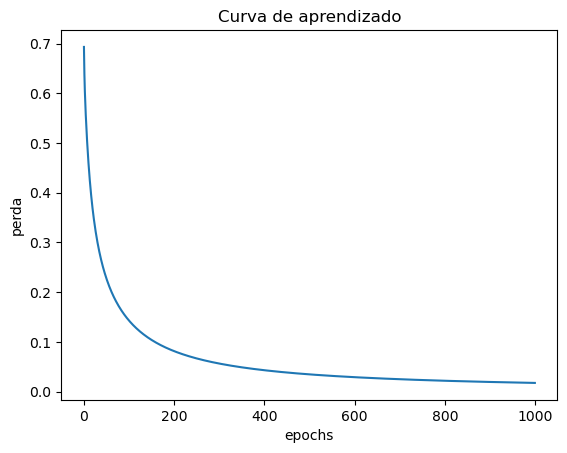

In [20]:
plt.figure()
plt.plot(perda)
plt.xlabel("epochs")
plt.ylabel("perda")
plt.title("Curva de aprendizado")
plt.show()

Vamos agora testar o modelo para as amostras de treinamento:

In [21]:
y_pred = logistic(linear(w, b, X))
for _x, _y in zip(X, y_pred):
    print(f'Entrada: ({_x[0]}, {_x[1]}), saida: {_y[0]:.2f}')

Entrada: (0.0, 0.0), saida: 0.00
Entrada: (0.0, 1.0), saida: 0.02
Entrada: (1.0, 0.0), saida: 0.02
Entrada: (1.0, 1.0), saida: 0.97


Parece que funcionou bem!

Relembrando: para fazer a regressão logística acontecer precisamos dos seguintes ingredientes:

- O modelo
- A função de perda
- O algoritmo de otimização
    - Este inclui a definição de como inicializar os parâmetros do modelo!
    
Sempre que formos trabalhar com redes neurais teremos que especificar todos esses ingredientes.

## Autodiff

Uma das coisas complicadas do código acima é ter que determinar manualmente (papel e caneta, ou processador simbólico) a derivada da perda média em relação aos parâmetros. É um processo maçante e sujeito a erros de atenção. Ou seja, é o caso perfeito para o uso de computadores!

Em uma primeira abordagem podemos imaginar o calculo da derivada da perda média usando um processo numérico simples:

$$
\frac{df}{dx} \approx \frac{\Delta f}{\Delta x}
$$

Por exemplo, suponha que desejamos calcular o gradiente da função $f(x, y) = x^2 y + y + 2$ (o exemplo do livro) no ponto $x = 3, y = 4$:

In [22]:
def f(x, y):
    return x**2 * y + y + 2


def gradiente_numerico(f, x, y):  # Vale para qualquer função f.
    h = 1e-3
    fx = (f(x + h, y) - f(x, y)) / h
    fy = (f(x, y + h) - f(x, y)) / h
    return fx, fy


x = 3
y = 4

print(f(x, y))

grad_x, grad_y = gradiente_numerico(f, x, y)
print(grad_x, grad_y)

42
24.003999999997916 9.99999999999801


Parece bom, mas sofre de problemas de precisão numérica para funções mais complicadas. Podemos também respirar fundo e determinar o gradiente analiticamente (i.e. "na mão"):

In [23]:
def gradiente_analitico(x, y):  # Só vale para a função f(x,y) acima.
    fx = 2 * x * y
    fy = x**2 + 1
    return fx, fy


grad_x, grad_y = gradiente_analitico(x, y)

print(grad_x, grad_y)

24 10


Neste caso a precisão é máxima, mas temos que mudar todo o código toda vez que a função for modificada. Além disso, para funções muito complicadas essa abordagem leva muito tempo.

A abordagem mais comum para o cálculo de derivadas em *deep learning* é a auto-diferenciação. Nesta abordagem, a computação é vista como um *grafo* direcionado pelo qual fluem valores. Por exemplo, a função $f(x) = x^2 y + y + 2$ pode ser representada pelo grafo abaixo:

![](flow.png)

A computação flui da entrada para a saída conforme ilustrado abaixo:

![](flow2.png)

Joia, mas e como calcular a derivada do resultado em relação às variáveis iniciais $x$ e $y$? Para tanto vamos lembrar da *regra da cadeia*: se $y = h(g(f(x)))$, então

$$
\frac{dy}{dx} = \frac{dh}{dg} \cdot \frac{dg}{df} \cdot \frac{df}{dx} 
$$

Note que cada função ($f(\cdot)$, $g(\cdot)$, etc.) necessita apenas de calculo de sua própria derivada. A derivada completa é obtida através da composição das várias derivadas existentes.

Quando o processo de cálculo das derivadas começa da última função ($h(\cdot)$) e vai sendo acumulado do fim para o começo temos o chamado *reverse-mode autodiff*. Começamos com o valor $1$ no final, pois é a derivada da saída contra ela mesma:

![](reverse1.png )

Agora propagamos de volta (em inglês: *back-propagate*!) esses gradientes da saída do bloco para a entrada do bloco:

![](reverse2.png )

Continuamos o processo:

![](reverse3.png)

Mais um pouco:

![](reverse4.png)

E para terminar:

![](reverse5.png)

Ufa! Esse processo parece complicado (e é!) e maçante (idem!), mas é *á prova de bala*: pode ser implementado em um computador! Tudo que temos que fazer é implementar os blocos, e neles implementar dois métodos: `evaluate()` calcula o valor do bloco baseado nas entradas, e `backpropagate()` calcula os gradientes *nas entradas* baseado no gradiente recebido *na saida*!

**Atividade**: Construa o grafo computacional da função $f(x, y) = x sin(y) + 4 y$ e simule o calculo do gradiente $\nabla f(4, 2)$.

E para provar que isso funciona, vamos implementar um grafo computacional simples. Vamos começar pela classe que representa a constante:

In [24]:
class Const:

    def __init__(self, value):
        self.value = value

    def evaluate(self):
        return self.value

    def backpropagate(self, gradient):
        # Ignora a propagação de gradiente para uma simples constante,
        # não faz sentido.
        pass

    def __str__(self):
        return str(self.value)

In [25]:
dois = Const(2.0)
print(dois)

2.0


Vamos agora implementar as variáveis. Variáveis e constantes são o ponto de partida do grafo computacional, e portanto são o ponto terminal do processo de *backpropagation* do gradiente. Em uma variável, todo gradiente recebido é acumulado.

In [26]:
class Var:

    def __init__(self, name, init_value=0):
        self.value = init_value
        self.name = name

    def evaluate(self):
        # Um bom lugar para resetar o gradiente antes do backpropagate.
        self.gradient = 0.0
        return self.value

    def backpropagate(self, gradient):
        # Acumula os gradientes recebidos.
        self.gradient += gradient

    def __str__(self):
        return f"({self.name}:{self.value})"

In [27]:
x = Var("x", 3.0)
y = Var("y", 4.0)
print(x, y)
print(x.evaluate(), y.evaluate())

(x:3.0) (y:4.0)
3.0 4.0


As próximas operações recebem valores de entrada e produzem valores de saida. Vamos começar pela soma:

In [28]:
class Add:

    def __init__(self, a, b):
        self.a = a  # Uma entrada.
        self.b = b  # Outra entrada.

    def evaluate(self):
        self.value = self.a.evaluate() + self.b.evaluate()
        return self.value

    def backpropagate(self, gradient):
        self.a.backpropagate(gradient)
        self.b.backpropagate(gradient)

    def __str__(self):
        return f"{self.a} + {self.b}"

In [29]:
soma_dois = Add(x, dois)
print(soma_dois)
print(soma_dois.evaluate())

(x:3.0) + 2.0
5.0


Com a multiplicação temos que tomar um cuidado: se $f(x,y) = x y$, então $\frac{\partial f}{\partial x} = y$ e $\frac{\partial f}{\partial y} = x$.

Então na hora de *backpropagate* os gradientes, temos que propaga-los diferentemente para cada entrada:

In [30]:
class Mul:

    def __init__(self, a, b):
        self.a = a  # Uma entrada.
        self.b = b  # Outra entrada.

    def evaluate(self):
        self.value = self.a.evaluate() * self.b.evaluate()
        return self.value

    def backpropagate(self, gradient):
        self.a.backpropagate(gradient * self.b.value)
        self.b.backpropagate(gradient * self.a.value)

    def __str__(self):
        return f"({self.a}) * ({self.b})"

In [31]:
a = Mul(x, x)
print(a)
print(a.evaluate())

((x:3.0)) * ((x:3.0))
9.0


Com isso temos todos os elementos para construir nosso grafo computacional para a função $f(x, y) = x^2 y + y + 2$:

In [32]:
x = Var("x", 3.0)
y = Var("y", 4.0)

a = Mul(x, x)
b = Mul(a, y)
c = Add(b, y)
z = Add(c, Const(2.0))

print(z)
print(z.evaluate())

(((x:3.0)) * ((x:3.0))) * ((y:4.0)) + (y:4.0) + 2.0
42.0


Funciona! Mas e os gradientes? Primeiro vamos retro-propagar (*backpropagate*?) os gradientes, começando pelo $\frac{dz}{dz} = 1$:

In [33]:
z.backpropagate(1.0)

E agora vamos consultar os valores dos gradientes:

In [34]:
x.gradient

24.0

In [35]:
y.gradient

10.0

Funcionou perfeitamente!

**Atividade**: Implemente um nó que calcula $sin(x)$. Implemente o grafo da função da atividade anterior: $f(x, y) = x sin(y) + 4 y$. Compare seus resultados.

## Implementando a regressão logística com autodiff

Para mostrar que esse tal de autodiff funciona para aplicações reais, vamos implementar a regressão logística com o autodiff. Para isso precisamos de mais dois blocos:

In [ ]:
class Log:

    def __init__(self, a):
        self.a = a

    def evaluate(self):
        self.value = np.log(self.a.evaluate())
        return self.value

    def backpropagate(self, gradient):
        self.a.backpropagate(gradient * 1.0 / self.a.value)

    def __str__(self):
        return f"log({self.a})"


class Logistic:

    def __init__(self, a):
        self.a = a

    def evaluate(self):
        self.value = 1.0 / (1.0 + np.exp(-self.a.evaluate()))
        return self.value

    def backpropagate(self, gradient):
        self.a.backpropagate(gradient * self.value * (1.0 - self.value))

    def __str__(self):
        return f"s({self.a})"

Agora vamos implementar a regressão logística. Vamos apenas rodar o passo de otimização por um número fixo de vezes para simplificar o código.

In [ ]:
eta = 1.0
max_iter = 1000

Xs = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
]
ys = [0, 0, 0, 1]
m = len(Xs)

# Constantes auxiliares.
minus = Const(-1)
one = Const(1)

# Estas são as verdadeiras variáveis do problema: os pesos e a constante!
w0 = Var("w0", init_value=0.0)
w1 = Var("w1", init_value=0.0)
b = Var("b", init_value=0.0)

for epoch in range(max_iter):
    #
    # PASSO 1: Calcula a função de perda sobre todas as amostras.
    #

    loss = Const(0)  # Todos os valores tem que ser convertidos para objetos.
    # Para cada amostra de treinamento.
    for xval, yval in zip(Xs, ys):
        # Cria objetos para as features e o target.
        x0 = Const(xval[0])
        x1 = Const(xval[1])
        y = Const(yval)

        # Cria o objeto da predição.
        y_pred = Logistic(Add(b, Add(Mul(x0, w0), Mul(x1, w1))))

        # Cria a parcela da função de perda correspondente a esta amostra de
        # treinamento.
        loss = Add(
            loss,
            Mul(
                minus,
                Add(
                    Mul(  # y * log(yhat)
                        y,
                        Log(y_pred),
                    ),
                    Mul(  # (1 - y) * log(1 - yhat)
                        Add(one, Mul(minus, y)),
                        Log(Add(one, Mul(minus, y_pred))),
                    ),
                ),
            ),
        )
    loss = Mul(Const(1 / m), loss)  # Para tirar a média.
    loss.evaluate()

    #
    # PASSO 2: Calcula as derivadas da perda em relação às variáveis (i.e.
    # os pesos e a constante).
    #
    loss.backpropagate(1.0)

    # PASSO 3: Executa o passo de aprendizado do algoritmo.
    w0.value -= eta * w0.gradient
    w1.value -= eta * w1.gradient
    b.value -= eta * b.gradient

In [ ]:
print(w0, w1, b)

In [ ]:
for xval, yval in zip(Xs, ys):
    x0 = Const(xval[0])
    x1 = Const(xval[1])
    y = Const(yval)
    y_pred = Logistic(Add(b, Add(Mul(x0, w0), Mul(x1, w1))))
    y_pred.evaluate()
    print(x0, x1, y, y_pred.value)

## Tensorflow

TensorFlow é uma biblioteca para computação distribuída, incluindo GPUs. A biblioteca TensorFlow permite o processamento de **tensores** (matrizes n-dimensionais: um valor solitário é um tensor de grau zero, uma lista de valores é um tensor de grau 1, uma matriz é um tensor de grau 2, etc) através de um *grafo de computação* sobre o qual os dados **fluem** (daí o nome TensorFlow).

A idéia básica é a seguinte:

- Os dados são tabelas n-dimensionais. O caso mais comum é matrizes.

- A computação é definida como um grafo

TensorFlow foi criado para trabalhar com dados em larga escala: podemos construir modelos com milhões de parâmetros e bilhões de pontos de dados! Aliás, é para isso que a biblioteca foi criada pelo time de machine learning do Google (o projeto Google Brain), e é usado em serviços de larga escala como o Google Search, Google Photos, etc.

**Instalação**

```bash
pip install tensorflow
```

Se você tem uma GPU NVidia compatível com a biblioteca CUDA, você também precisa instalar os drivers CUDA. Siga as instruções completas de instalação do TensorFlow em https://www.tensorflow.org/install.

Você pode também rodar os notebooks desta seção do curso no Google Colab: https://colab.research.google.com/

**Documentação**

https://www.tensorflow.org/programmers_guide/



In [ ]:
import tensorflow as tf

Vamos implementar a regressáo logística mais uma vez, mas agora com TensorFlow:

In [ ]:
@tf.function
def linear_tf(w, b, X):
    return X @ w + b


@tf.function
def logistic_tf(x):
    return 1.0 / (1.0 + tf.math.exp(-x))


@tf.function
def model(w, b, X):
    return logistic_tf(linear_tf(w, b, X))


@tf.function
def cross_entropy_tf(y, y_pred):
    m = y.shape[0]
    cross = (1.0 / m) * tf.reduce_sum(-y * tf.math.log(y_pred) -
                                      (1 - y) * tf.math.log(1 - y_pred))
    return cross


@tf.function
def loss_tf(X, y, w, b):
    y_pred = model(w, b, X)
    return cross_entropy_tf(y, y_pred)


X = tf.constant([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])
y = tf.constant([
    [0.0],
    [0.0],
    [0.0],
    [1.0],
])

w = tf.Variable([[0.0], [0.0]])
b = tf.Variable(0.0)

epochs = 1000
eta = 1.0

for epoch in range(epochs):
    # GradientTape é o mecanismo de contabilidade dos gradientes no TensorFlow.
    with tf.GradientTape() as tape:
        eps = loss_tf(X, y, w, b)
    grad_w, grad_b = tape.gradient(eps, [w, b])
    w.assign_sub(eta * grad_w)
    b.assign_sub(eta * grad_b)

In [ ]:
w

In [ ]:
b

In [ ]:
model(w, b, X)

Se você monitorar o uso da sua GPU verá que ela será posta em ação neste código:

![](cuda.png)

Observe que o TensorFlow alocou quase toda a memória da sua GPU (por precaução) e acionou os processadores numéricos da GPU. Este é um exemplo pequeno, e quase todo o trabalho da GPU foi criar os *kernels* de processamento, copiar dados da memória principal (*host memory*, a *RAM* da sua máquina) para a memória da GPU (*device memory*), e copiar de volta esses dados (*device-to-host* agora).

Podemos trocar nosso *gradient descent* simples por um outro regime de *gradient descent* mais sofisticado como o Adam (Adaptive Moment Estimation) usando os otimizadores pré-implementados do TensorFlow:

In [ ]:
@tf.function
def linear_tf(w, b, X):
    return X @ w + b


@tf.function
def logistic_tf(x):
    return 1.0 / (1.0 + tf.math.exp(-x))


@tf.function
def model(w, b, X):
    return logistic_tf(linear_tf(w, b, X))


@tf.function
def cross_entropy_tf(y, y_pred):
    m = y.shape[0]
    cross = (1.0 / m) * tf.reduce_sum(-y * tf.math.log(y_pred) -
                                      (1 - y) * tf.math.log(1 - y_pred))
    return cross


@tf.function
def loss_tf(X, y, w, b):
    y_pred = model(w, b, X)
    return cross_entropy_tf(y, y_pred)


X = tf.constant([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])
y = tf.constant([
    [0.0],
    [0.0],
    [0.0],
    [1.0],
])

w = tf.Variable([[0.0], [0.0]])
b = tf.Variable(0.0)

epochs = 1000
alpha = 1.0

# Para usar um otimizador, precisamos criá-lo.
optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

for _ in range(epochs):
    # O otimizador tem dois argumentos: uma função sem parâmetros (estranho!)
    # e uma lista de variáveis que serão otimizadas.
    optimizer.minimize(lambda: loss_tf(X, y, w, b), var_list=[w, b])

# Após rodar vários epochs (passagens completas pelos dados) temos nas
# próprias variáveis w e b os seus valores ótimos.

In [ ]:
w

In [ ]:
b

In [ ]:
model(w, b, X)

## Uma rede neural multicamadas

Uma camada de uma rede neural é simplesmente uma chamada da função `linear` seguida de uma chamada de uma *função de ativação* (a função logística é um exemplo de função de ativação). Uma rede neural multicamadas é uma sequência de camadas. Simples! 

As redes multicamadas são necessárias para resolver problemas mais complexos, que não podem ser resolvidos por uma regressão logística simples. Por exemplo, como uma regressão logística resolveria o seguinte problema?

In [ ]:
X = tf.constant([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])
y = tf.constant([
    [0.0],
    [1.0],
    [1.0],
    [0.0],
])

**Atividade**: Tente achar pesos e constante que resolvam o problema acima com regressão logística.

**R**:

Vamos implementar uma rede neural multicamadas, com funções de ativação diferentes. Uma das funções de ativação mais populares recentemente é a "Rectified Linear Unit" - ReLU:

In [ ]:
@tf.function
def relu_tf(x):
    return tf.math.maximum(x, 0.0)

Nossa função `linear` já trabalha com multiplas entradas e multiplas saidas: basta usar uma matriz `w` para os pesos que seja compatível com os tamanhos de entrada e saída. O mesmo vale para os pesos `b`. Vamos fazer uma camada de rede neural que tem duas entradas e duas saídas, com função de ativação relu, seguida de uma camada de duas entradas e uma saída, com função de ativação sigmoide. Vamos otimizar essa rede usando um otimizador Adam. A função de perda será, como de costume, a entropia cruzada.

In [ ]:
@tf.function
def linear_tf(w, b, X):
    return X @ w + b


@tf.function
def logistic_tf(x):
    return 1.0 / (1.0 + tf.math.exp(-x))


@tf.function
def model(w0, b0, w1, b1, X):
    layer1 = relu_tf(linear_tf(w0, b0, X))
    layer2 = logistic_tf(linear_tf(w1, b1, layer1))
    return layer2


@tf.function
def cross_entropy_tf(y, y_pred):
    m = y.shape[0]
    cross = (1.0 / m) * tf.reduce_sum(-y * tf.math.log(y_pred) -
                                      (1 - y) * tf.math.log(1 - y_pred))
    return cross


@tf.function
def loss_tf(X, y, w0, b0, w1, b1):
    y_pred = model(w0, b0, w1, b1, X)
    return cross_entropy_tf(y, y_pred)


w0 = tf.Variable([
    [1.0, 1.0],
    [-1.0, -1.0],
])

b0 = tf.Variable([
    [0.5, 0.5],
])

w1 = tf.Variable([
    [1.0],
    [-1.0],
])

b1 = tf.Variable(0.5)

epochs = 1000
alpha = 0.1

# Para usar um otimizador, precisamos criá-lo.
optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)
opt_loss = lambda: loss_tf(X, y, w0, b0, w1, b1)

for epoch in range(epochs):
    # O otimizador tem dois argumentos: uma função sem parâmetros (estranho!)
    # e uma lista de variáveis que serão otimizadas.
    optimizer.minimize(opt_loss, var_list=[w0, b0, w1, b1])
    if epoch % 100 == 0:
        print(opt_loss())

In [ ]:
model(w0, b0, w1, b1, X)

In [ ]:
w0

In [ ]:
b0

In [ ]:
w1

In [ ]:
b1

Claro, eu inicializei os pesos na mão, para fazer convergir! Vamos ver nas outras aulas como criar redes neurais "de verdade" usando Keras, e vamos discutir aspectos como inicialização, convergência, regularização, etc. Até a próxima!